# 필요한 모듈 import

In [1]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pandas as pd
import numpy as np

import time
import re
import os

from math import sqrt

어려웠던 부분
1. 연봉 정보를 긁어올 때 팀 정보를 나타내는 리스트 버튼을 클릭하고 그 리스트의 두번째 팀을 클릭해야 오류가 안 생겼다. 그 이유는 모르겠다.
-> 그 이유를 계속 고민하다가 우연히 두번째 리스트를 클릭하니 해결했다. wait의 방법의 문제일까 했지만 이런 식으로 해결할 수 있었다. 반복문 안으로 들어가기 전 '전체'를 처음부터 누르도록 해야지 되는 것 같다.
2. 연봉 정보에서 팀 전체에 대한 선수들의 연봉 정보도 같이 받아 당연히 중복되는 값이 나오는 것인데 그 이유를 몰라 많이 헤맸다.
-> find_duplicates 함수를 만들어 확인해가며 그 이유를 천천히 알아낼 수 있었다.

# 투수 정보 스크래핑 (출처 : KBO 공식 사이트) 
- https://www.koreabaseball.com/Record/Player/HitterBasic/Basic1.aspx?sort=HRA_RT

In [2]:
# driver을 종료하지 않았는데 창이 닫히는 문제 해결하기 위한 옵션을 설정하는 함수
def make_driver_by_detatch_option():
    # 옵션 객체 생성
    options = Options()
    # 'detach' 옵션을 True 로 설정하여 스크립트 실행이 끝난 후에도 브라우저가 열려있게 만든다.
    options.add_experimental_option("detach", True)
    # 설정한 옵션 적용
    driver = webdriver.Chrome(options=options)
    return driver

In [3]:
driver = make_driver_by_detatch_option()

# 명시적 wait 설정과 time.sleep()을 사용해 웹을 안정적으로 제어한다.
driver.implicitly_wait(5)

driver.get('https://www.koreabaseball.com/Record/Player/PitcherBasic/Basic1.aspx')
time.sleep(1)

# 년도 선택을 하는 combo박스를 클릭한다.
driver.find_element(By.CSS_SELECTOR, 'div.compare > select').click()
time.sleep(1)

# combo박스안 value 속성이 2023인 요소를 클릭한다.
driver.find_element(By.CSS_SELECTOR, 'option[value="2023"]').click()
time.sleep(1)

# 승리수 컬럼을 눌러야 전체 데이터가 정렬되며 뒤의 데이터를 불러온다. (게임수 컬럼을 눌러서 진행할 수도 있다.)
driver.find_element(By.CSS_SELECTOR, 'tr > th > a[title="승리"]').click()
time.sleep(1)

# 피처들을 받아온다.
th_tags = driver.find_elements(By.CSS_SELECTOR, 'tr > th')

# 피처들을 저장할 리스트 초기화
columns = []
for th_tag in th_tags:
    columns.append(th_tag.text.strip())

# 총 10페이지에 걸친 데이터가 있다.
page = 10

# row데이터를 저장할 리스트 초기화
row = []
for p in range(1,page+1):
    
    #행 1개의 데이터를 담을 리스트 초기화
    row_1 = []
    
    #페이지 버튼들 가져오기
    page_buttons = driver.find_elements(By.CSS_SELECTOR, 'div.paging > a')
    
    # 반복문 내 페이지 순서와 button의 text가 같다면 클릭(zip으로 언패킹해서 파라미터에 전달하면 가능할지도?)
    for button in page_buttons:
        if button.text == str(p):
            button.click()
            time.sleep(1)
            break
    
    # 행 데이터를 가져온다 tbody -> tr -> td안에 텍스트 정보를 하나의 리스트로 저장해 row리스트에 append
    tr_tags = driver.find_elements(By.CSS_SELECTOR, 'tbody > tr')
    for tr_tag in tr_tags:
        td_tags = tr_tag.find_elements(By.CSS_SELECTOR, 'td')
        row_1 = [td_tag.text.strip() for td_tag in td_tags]
        row.append(row_1)
    print("succeed")
    
    # 5개의 페이지가 끝나면 다음 페이지를 눌러야 한다.
    if p % 5 == 0 and p != 10:
        driver.find_element(By.CSS_SELECTOR, 'div.paging > a[title="다음 페이지로 이동"]').click()
        time.sleep(1)    

# 최종 데이터 데이터 프레임으로 저장
df = pd.DataFrame(data = row, columns = columns)

# 드라이버 종료
driver.quit()

succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed
succeed


In [4]:
print(df.shape)
df.head()

(285, 19)


,순위,선수명,팀명,ERA,G,W\n승리,L,SV,HLD,WPCT,IP,H,HR,BB,HBP,SO,R,ER,WHIP
0,1,페디,NC,2.00,30,20,6,0,0,0.769,180 1/3,137,9,35,4,209,46,40,0.95
1,2,벤자민,KT,3.54,29,15,6,0,0,0.714,160,149,12,45,3,157,79,63,1.21
2,3,임찬규,LG,3.42,30,14,3,0,1,0.824,144 2/3,142,10,54,5,103,63,55,1.35
3,4,알칸타라,두산,2.67,31,13,9,0,0,0.591,192,171,16,35,5,162,67,57,1.07
4,5,고영표,KT,2.78,28,12,7,0,0,0.632,174 2/3,181,7,19,9,114,57,54,1.15


# 연봉 정보(2023년) 크롤링 (출처 : 스탯티즈 사이트) 
- https://statiz.sporki.com/add/?m=salary)

In [5]:
def get_salary_data(year):
    driver = make_driver_by_detatch_option()
    driver.implicitly_wait(5)

    driver.get(f'https://statiz.sporki.com/add/?m=salary&year={year}&ct_code=')
    time.sleep(1)

    # 컬럼 이름을 받아온다.
    columns = []
    th_tags = driver.find_elements(By.CSS_SELECTOR, 'thead > tr > th')

    for th_tag in th_tags:
        columns.append(th_tag.text.strip())

    # 팀 정보 리스트 버튼을 클릭해서 전체 팀의 선수들의 연봉 정보를 받아온다.
    driver.find_element(By.CSS_SELECTOR, 'div#select_cteam').click()
    time.sleep(1)
    # li_tags = driver.find_elements(By.CSS_SELECTOR, 'ul.option_list[style="width:18rem;"] > li')
    li_tags = driver.find_elements(By.CSS_SELECTOR, 'div#select_cteam > ul > li')
    count_li_tags = len(li_tags)
    # 암튼 이렇게 하니까 되더라... 이유는 모르겠네
    li_tags[1].click()

    # 행 정보 크롤링
    row = []
    for i in range(count_li_tags):
        time.sleep(1)
        driver.find_element(By.CSS_SELECTOR, 'div#select_cteam').click()
        time.sleep(2)
        # li_tags = driver.find_elements(By.CSS_SELECTOR, 'ul.option_list[style="width:18rem;"] > li')
        li_tags = driver.find_elements(By.CSS_SELECTOR, 'div#select_cteam > ul > li')

        # 팀 정보 화면에 출력하고 그 팀의 선수들의 연봉 정보를 불러온다.
        print(li_tags[i].text)
        li_tags[i].click()

        tr_tags = driver.find_elements(By.CSS_SELECTOR, 'tbody > tr')
        # tr태그 안에서 텍스트가 있는 태그가 다 다르다,
        for tr_tag in tr_tags:
            row_1 = []
            for i, td_tag in enumerate(tr_tag.find_elements(By.CSS_SELECTOR, 'td')):
                if i == 0:
                    row_1.append(td_tag.find_element(By.CSS_SELECTOR, 'a').text)
                elif i == 2:
                    row_1.append(td_tag.find_element(By.CSS_SELECTOR, 'div').text)
                else:
                    row_1.append(td_tag.text)
            row.append(row_1)

    df_salary = pd.DataFrame(data = row, columns = columns)

    driver.quit()
    
    return df_salary

In [6]:
df_salary = get_salary_data(2023)

전체
해태+KIA
삼성
OB+두산
SK+SSG
삼미+청보+태평양+현대
MBC+LG
롯데
빙그레+한화
NC
KT
히어로즈+넥센+키움
쌍방울


In [7]:
print(df_salary.shape)
df_salary.head()

(969, 5)


,선수,연도,팀,연봉(만원),WAR
0,구자욱,2023,삼성,"200,000",5.44
1,채은성,2023,한화,"180,000",2.36
2,추신수,2023,SSG,"170,000",1.46
3,박세웅,2023,롯데,"150,000",4.63
4,김재환,2023,두산,"150,000",0.48


# 중복값 처리

In [8]:
# 연봉 정보에 중복된 선수가 나오는 것을 확인하기 위해 만든 함수 (각 팀 선수의 연봉정보와 콤보 박스 전체에 해당하는 선수들의 연봉을 가져왔기 때문)
def find_duplicates(lst):
    return list(set([item for item in lst if lst.count(item) > 1]))
duplicate_lst = find_duplicates(df_salary['선수'].tolist())
duplicate_lst

['최정',
 '로하스',
 '쿠에바스',
 '박민우',
 '후라도',
 '허경민',
 '양현종',
 '알포드',
 '엘리아스',
 '안치홍',
 '노진혁',
 '문승원',
 '와이드너',
 '백정현',
 '이병헌',
 '이정훈',
 '김동혁',
 '뷰캐넌',
 '이용규',
 '김재호',
 '최원태',
 '이승현',
 '김현수',
 '딜런',
 '반즈',
 '마틴',
 '요키시',
 '원종현',
 '최주환',
 '박민호',
 '원태인',
 '최지훈',
 '박준영',
 '박주현',
 '김재윤',
 '벤자민',
 '소형준',
 '오스틴',
 '오지환',
 '유강남',
 '정우람',
 '홍건희',
 '김민수',
 '조용호',
 '이정후',
 '정우영',
 '홍창기',
 '황재균',
 '슐서',
 '김태우',
 '피렐라',
 '최재훈',
 '장성우',
 '최원준',
 '산체스',
 '강민호',
 '구자욱',
 '박성재',
 '김혜성',
 '이지영',
 '정수빈',
 '김범준',
 '최형우',
 '박해민',
 '알칸타라',
 '김재환',
 '박병호',
 '채은성',
 '김태훈',
 '페디',
 '박세혁',
 '맥카티',
 '이재원',
 '양의지',
 '박세웅',
 '켈리',
 '김광현',
 '김민혁',
 '수아레즈',
 '안우진',
 '이민호',
 '오그레디',
 '스미스',
 '정훈',
 '오재일',
 '배정대',
 '김상수',
 '고우석',
 '김성진',
 '박종훈',
 '로메로',
 '러셀',
 '한유섬',
 '홍원기',
 '렉스',
 '플럿코',
 '에레디아',
 '이태양',
 '앤더슨',
 '소크라테스',
 '구창모',
 '박동원',
 '서동욱',
 '고영표',
 '박건우',
 '전준우',
 '파노니',
 '이원석',
 '김선빈',
 '추신수',
 '양석환',
 '이주형',
 '스트레일리',
 '나성범',
 '김건웅',
 '이용찬',
 '구드럼',
 '페냐',
 '손아섭',
 '오승환',
 '김재현']

In [9]:
# df와 df_salary와 컬럼명을 동일하게 하기 위해(나중에 join을 위해서) 컬럼명을 수정한다.
df_salary = df_salary.rename(columns={'선수':'선수명', '팀':'팀명'})

In [10]:
# df_salary에 이름과 팀이 같으면 같은 정보이므로 그것을 첫번째 행만 남기고 나머지는 삭제한다.
# df_salary_cleaned = df_salary.drop_duplicates(subset=['선수명', '팀'], keep='first')
df_salary_cleaned = df_salary.drop_duplicates(keep='first')

In [11]:
# 2024 연봉 정보 가져오기
df_salary_2024 = get_salary_data(2024)

전체
해태+KIA
삼성
OB+두산
SK+SSG
삼미+청보+태평양+현대
MBC+LG
롯데
빙그레+한화
NC
KT
히어로즈+넥센+키움
쌍방울


In [12]:
# 2023년과 동일하게 선수를 선수명으로 바꾸고 중복된 값을 처리한다.
df_salary_2024 = df_salary_2024.rename(columns={'선수':'선수명', '팀':'팀명'})
df_salary_cleaned_2024 = df_salary_2024.drop_duplicates(keep='first')

In [13]:
# 투수 정보가 담긴 df에서도 중복된 데이터를 확인해본다. (선수명과 팀명이 같으면 연봉 정보를 merge할 수 없기 때문에 그냥 삭제한다.)
duplicats_names = find_duplicates(df['선수명'].tolist())
double_duplicats = []
for name in duplicats_names:
    if len(set(df.loc[df['선수명']==name, '팀명'].values)) == 1: double_duplicats.append(name)
double_duplicats

['이승현']

In [14]:
df_salary[df_salary['선수명']=='이승현']

,선수명,연도,팀명,연봉(만원),WAR
199,이승현,2023,삼성,"12,000",0.55
202,이승현,2023,삼성,"8,000",0.05


In [15]:
# 두 선수는 주어진 정보로 구별할 방법이 없어 그냥 삭제한다.
df = df[df['선수명'] != '이승현']

# 데이터 합치기

In [16]:
# df와 df_salary_cleaned를 선수명과 팀을 기준으로 inner조인한다.
df_player_salary_2023 = pd.merge(df, df_salary_cleaned, on=['선수명','팀명'], how='inner')
df_player_salary_2023.head()

,순위,선수명,팀명,ERA,G,W\n승리,L,SV,HLD,WPCT,...,HR,BB,HBP,SO,R,ER,WHIP,연도,연봉(만원),WAR
0,1,페디,NC,2.00,30,20,6,0,0,0.769,...,9,35,4,209,46,40,0.95,2023,"80,000",7.95
1,2,벤자민,KT,3.54,29,15,6,0,0,0.714,...,12,45,3,157,79,63,1.21,2023,"100,000",2.90
2,3,임찬규,LG,3.42,30,14,3,0,1,0.824,...,10,54,5,103,63,55,1.35,2023,"17,000",3.40
3,4,알칸타라,두산,2.67,31,13,9,0,0,0.591,...,16,35,5,162,67,57,1.07,2023,"50,000",5.79
4,5,고영표,KT,2.78,28,12,7,0,0,0.632,...,7,19,9,114,57,54,1.15,2023,"43,000",5.91


In [17]:
df_player_salary_2023.shape

(282, 22)

In [18]:
# 2023년 투수와 연봉 정보가 담긴 데이터프레임에 2024년 연봉을 inner 조인해서 최종 players 데이터 프레임을 만든다.
players = pd.merge(df_player_salary_2023, df_salary_cleaned_2024, on=['선수명','팀명'], how='inner', suffixes=('_2023','_2024'))
# 그 중 필요없는 열인 것들을 삭제한다.
players = players.drop(columns=['WAR_2024','연도_2023','연도_2024', '순위'])

In [19]:
print(players.shape)
players.head()

(208, 21)


,선수명,팀명,ERA,G,W\n승리,L,SV,HLD,WPCT,IP,...,HR,BB,HBP,SO,R,ER,WHIP,연봉(만원)_2023,WAR_2023,연봉(만원)_2024
0,벤자민,KT,3.54,29,15,6,0,0,0.714,160,...,12,45,3,157,79,63,1.21,"100,000",2.90,"90,000"
1,임찬규,LG,3.42,30,14,3,0,1,0.824,144 2/3,...,10,54,5,103,63,55,1.35,"17,000",3.40,"20,000"
2,알칸타라,두산,2.67,31,13,9,0,0,0.591,192,...,16,35,5,162,67,57,1.07,"50,000",5.79,"80,000"
3,고영표,KT,2.78,28,12,7,0,0,0.632,174 2/3,...,7,19,9,114,57,54,1.15,"43,000",5.91,"200,000"
4,쿠에바스,KT,2.60,18,12,0,0,0,1.000,114 1/3,...,4,24,2,100,33,33,1.04,"45,000",4.57,"100,000"


In [20]:
players = players.sample(frac=1).reset_index(drop=True)
players.head()

,선수명,팀명,ERA,G,W\n승리,L,SV,HLD,WPCT,IP,...,HR,BB,HBP,SO,R,ER,WHIP,연봉(만원)_2023,WAR_2023,연봉(만원)_2024
0,김대현,LG,10.80,5,0,0,0,0,-,3 1/3,...,1,2,1,3,5,4,3.00,"6,200",-0.08,"5,700"
1,곽빈,두산,2.90,23,12,7,0,0,0.632,127 1/3,...,7,58,5,106,44,41,1.21,"14,000",4.36,"21,000"
2,박치국,두산,3.59,62,5,3,2,11,0.625,52 2/3,...,3,21,5,48,22,21,1.42,"10,500",0.50,"13,000"
3,박세웅,롯데,3.45,27,9,7,0,0,0.563,154,...,8,59,4,129,70,59,1.32,"150,000",4.63,"135,000"
4,양지율,키움,13.50,1,0,0,0,0,-,2/3,...,0,3,0,2,1,1,6.00,"3,000",-0.02,"3,000"


# 데이터 엑셀 파일로 저장

In [21]:
# 향후 분석에 재활용하기 위해 데이터 프레임을 엑셀 파일로 저장
file_path = 'player_stats.xlsx'

if os.path.exists(file_path):
    print(f"{file_path} 파일이 이미 존재합니다.")
else:
    players.to_excel('player_stats.xlsx', index=False)

player_stats.xlsx 파일이 이미 존재합니다.


In [22]:
# 본격적인 분석은 엑셀 파일을 받아오면서 시작한다.
players = pd.read_excel('player_stats.xlsx')
print(players.shape)
players.head()

(209, 21)


,선수명,팀명,ERA,G,W,L,SV,HLD,WPCT,IP,...,HR,BB,HBP,SO,R,ER,WHIP,연봉(만원)_2023,WAR_2023,연봉(만원)_2024
0,김명신,두산,3.65,70,3,3,1,24,0.500,79,...,3,27,6,65,34,32,1.25,"14,500",0.95,"22,500"
1,김기중,한화,4.63,37,1,3,0,1,0.250,56 1/3,...,4,29,9,46,33,29,1.54,"3,600",0.67,"4,400"
2,김태훈,삼성,7.11,71,6,7,3,11,0.462,63 1/3,...,8,43,3,40,54,50,1.85,"18,000",-0.62,"17,000"
3,성동현,LG,9.00,1,0,0,0,0,-,1,...,0,1,0,1,1,1,3.00,"3,100",-0.01,"3,200"
4,김민수,KT,6.92,14,0,1,0,3,0.000,13,...,1,5,0,4,10,10,1.69,"25,000",-0.18,"16,000"


In [23]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   선수명          209 non-null    object 
 1   팀명           209 non-null    object 
 2   ERA          209 non-null    float64
 3   G            209 non-null    int64  
 4   W            209 non-null    int64  
 5   L            209 non-null    int64  
 6   SV           209 non-null    int64  
 7   HLD          209 non-null    int64  
 8   WPCT         209 non-null    object 
 9   IP           209 non-null    object 
 10  H            209 non-null    int64  
 11  HR           209 non-null    int64  
 12  BB           209 non-null    int64  
 13  HBP          209 non-null    int64  
 14  SO           209 non-null    int64  
 15  R            209 non-null    int64  
 16  ER           209 non-null    int64  
 17  WHIP         209 non-null    float64
 18  연봉(만원)_2023  209 non-null    object 
 19  WAR_2023

# 데이터 전처리

In [24]:
# 값들이 전부 string 형태로 돼있고 쉼표(,)가 포함돼있어 이것을 없애고 숫자형으로 바꿔준다.
players['연봉(만원)_2023'] = players['연봉(만원)_2023'].str.replace(',', '').astype(float)
players['연봉(만원)_2024'] = players['연봉(만원)_2024'].str.replace(',', '').astype(float)

In [25]:
# WPCT열에 '-'가 포함되어 있다 이를 nan으로 바꾸어 준다.
def replace_dash_with_nan(value):
    if value == '-':
        return np.nan
    else:
        return value

# '-'를 NaN으로 바꾼 후 astype(float) 적용
players['WPCT'] = players['WPCT'].apply(replace_dash_with_nan).astype(float)

# NAN으로 바꾼 것에 0으로 채워 넣는다.
players = players.fillna(0)
# players = players.dropna(subset='WPCT', ignore_index=True)

In [26]:
# 이닝을 뜻하는 IP에 분수 형태로(ex. 14 2/3)으로 표현된 것을 정규표현식으로 계산하여 숫자로 변환한다.
# 정규식을 사용하여 공백을 +로 대체하고 분수형태를 + 기호로 바꿈
players['IP'] = players['IP'].str.replace(r'\s', '+', regex=True).str.replace(r'(\d+)\+(\d+)/(\d+)', r'(\1+\2/\3)', regex=True)

# 문자열을 계산하여 숫자로 변환
players['IP'] = players['IP'].apply(lambda x: eval(x))

In [27]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   선수명          209 non-null    object 
 1   팀명           209 non-null    object 
 2   ERA          209 non-null    float64
 3   G            209 non-null    int64  
 4   W            209 non-null    int64  
 5   L            209 non-null    int64  
 6   SV           209 non-null    int64  
 7   HLD          209 non-null    int64  
 8   WPCT         209 non-null    float64
 9   IP           209 non-null    float64
 10  H            209 non-null    int64  
 11  HR           209 non-null    int64  
 12  BB           209 non-null    int64  
 13  HBP          209 non-null    int64  
 14  SO           209 non-null    int64  
 15  R            209 non-null    int64  
 16  ER           209 non-null    int64  
 17  WHIP         209 non-null    float64
 18  연봉(만원)_2023  209 non-null    float64
 19  WAR_2023

# 2024년 연봉 정보 시각화

In [28]:
# 그래프 설정 초기화 함수, 밑에서 그래프 설정을 바꾸는 경우가 있기에 이를 함수로 만들어주고
# 다시 시각화를 하는 데 불편함이 없게 한다
def pltconfig_default():
    sns.reset_defaults()
    # %matplotlib inline
pltconfig_default()

In [29]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

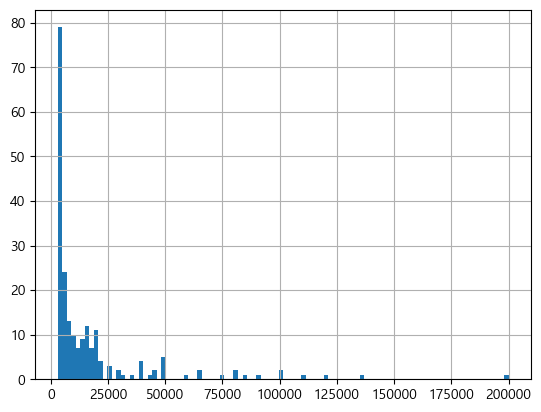

In [30]:
# 연봉의 전체적인 내용을 눈으로 살펴본다.
players['연봉(만원)_2024'].describe()
players['연봉(만원)_2024'].hist(bins=100)
plt.show()

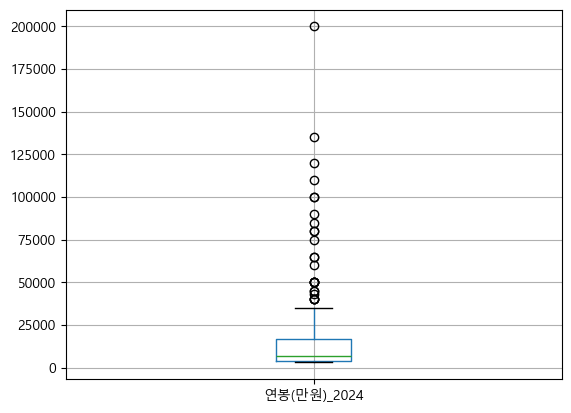

In [31]:
players.boxplot(column=['연봉(만원)_2024'])
plt.show()

# 원-핫 인코딩 (팀명 데이터 수정)

In [32]:
# 팀을 나타내는 컬럼을 원-핫 인코딩으로 전환해 players 데이터 프레임에 조인한다.
team_encoding = pd.get_dummies(players['팀명'])
players = players.drop('팀명', axis=1)
players = players.join(team_encoding.astype(int))

# minmaxscaler를 사용해서 추가적 데이터 전처리.

In [33]:
scale_columns = ['ERA', 'G', 'W', 'L', 'SV', 'HLD', 'WPCT', 'IP', 'H', 'HR', 'BB', 'HBP', 'SO', 'R', 'ER', 
                 'WHIP', '연봉(만원)_2023', 'WAR_2023',
                 'KIA', 'KT', 'LG', 'NC', 'SSG', '두산', '롯데', '삼성', '키움', '한화']

In [34]:
# 최종 시각화를 위해 last_players 데이터 프레임 만들어 두기
scaler = preprocessing.MinMaxScaler()
players[scale_columns] = scaler.fit_transform(players[scale_columns])
last_players = players.rename(columns={'연봉(만원)_2024':'y'})

In [35]:
scaler = preprocessing.MinMaxScaler()
scaled_data = scaler.fit_transform(players[scale_columns])
scaled_players = pd.DataFrame(scaled_data, columns=scale_columns)

In [36]:
# 스케일 된 scaled_players에 2024년 연봉 열을 join한다. 그리고 'y'라는 이름으로 컬럼이름을 변경한다.
scaled_players = scaled_players.join(players['연봉(만원)_2024'])
scaled_players = scaled_players.rename(columns={'연봉(만원)_2024':'y'})
scaled_players.head()

,ERA,G,W,L,SV,HLD,WPCT,IP,H,HR,...,KT,LG,NC,SSG,두산,롯데,삼성,키움,한화,y
0,0.045062,0.873418,0.200000,0.250000,0.023810,0.75000,0.500,0.410435,0.393443,0.1875,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22500.0
1,0.057160,0.455696,0.066667,0.250000,0.000000,0.03125,0.250,0.292174,0.316940,0.2500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4400.0
2,0.087778,0.886076,0.400000,0.583333,0.071429,0.34375,0.462,0.328696,0.404372,0.5000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,17000.0
3,0.111111,0.000000,0.000000,0.000000,0.000000,0.00000,0.000,0.003478,0.010929,0.0000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3200.0
4,0.085432,0.164557,0.000000,0.083333,0.000000,0.09375,0.000,0.066087,0.092896,0.0625,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16000.0


# 선형회귀

In [37]:
# 데이터를 train과 test로 나눈다.
X = scaled_players[scaled_players.columns.difference(['y'])]
y = scaled_players['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5, shuffle=True)

In [38]:
# 모델을 학습시키고 계수를 출력해본다.
model = LinearRegression()
model.fit(X_train, y_train)
# 학습된 계수 출력
model.coef_

array([-55061.88192878, -14611.98452688, -15092.05426358,  11169.07597178,
        22966.05164988,  23358.62563974,  -9859.65923144, -31473.34272215,
        39035.51415252,  -1370.65737096,   3697.86833241,  -7777.2656022 ,
        -6095.41647873,   1825.25258329,  11347.91821798,   3335.96486745,
         2925.52211785,   5671.48895922,  20317.08668062,  45936.9345147 ,
        19720.07372016,  -2062.33812818,  -2119.02515682,   -209.03932167,
         3400.94415388,  49587.87116127,    715.83451627,  -2771.28337551])

In [39]:
# 모델 평가하기
def model_evaluation():
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    mse = mean_squared_error(y_train, y_train_predict)

    print("training set에서 성능")
    print("-----------------------")
    print(f'오차: {sqrt(mse)}')

    mse = mean_squared_error(y_test, y_test_predict)

    print("testing set에서 성능")
    print("-----------------------")
    print(f'오차: {sqrt(mse)}')

    print(model.score(X_train, y_train))
    print(model.score(X_test, y_test))

In [40]:
# 모델 평가 함수 호출
model_evaluation()

training set에서 성능
-----------------------
오차: 10677.93379576044
testing set에서 성능
-----------------------
오차: 17679.88315040124
0.8026966007961975
0.6789530071553638


In [41]:
# lasso 모델 적용
model = Lasso(alpha=1, max_iter=3000)
model.fit(X_train, y_train)
model_evaluation()

training set에서 성능
-----------------------
오차: 10678.48836261168
testing set에서 성능
-----------------------
오차: 17646.047968565337
0.8026761060510003
0.6801806497777105


In [42]:
# Ridge 모델 적용
model = Ridge(alpha=1, max_iter=3000)
model.fit(X_train, y_train)
model_evaluation()

training set에서 성능
-----------------------
오차: 11287.873172184663
testing set에서 성능
-----------------------
오차: 17470.05020947595
0.7795123026061535
0.6865284495346049


# statsmodel 라이브러리의 OLS 클래스로 회귀 분석

In [43]:
X_train_ = sm.add_constant(X_train)
model_ = sm.OLS(y_train, X_train_).fit()
model_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     20.94
Date:                Wed, 10 Jul 2024   Prob (F-statistic):           1.34e-36
Time:                        12:58:04   Log-Likelihood:                -1786.0
No. Observations:                 167   AIC:                             3628.
Df Residuals:                     139   BIC:                             3715.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2991.3537   3384.928     -0.884      0.378   -9683.959    3701.251
BB          -5.506e+04    1.6e+04     -3.434      0.001   -8.68e+04   -2.34e+04
ER          -1.461e+04   4.38e+04     -0.333      0.739   -1.01e+05     7.2e+04
ERA         -1.509e+04   2.46e+04     -0.613      0.541   -6.38e+04    3.36e+04
G            1.117e+04   1.03e+04      1.079      0.282   -9289.876    3.16e+04
H            2.297e+04   3.52e+04      0.653      0.515   -4.66e+04    9.25e+04
HBP          2.336e+04   8181.817      2.855      0.005    7181.718    3.95e+04
HLD         -9859.6592   1.09e+04     -0.904      0.368   -3.14e+04    1.17e+04
HR          -3.147e+04   1.01e+04     -3.120      0.002   -5.14e+04   -1.15e+04
IP           3.904e+04   6.03e+04      0.647      0.518   -8.02e+04    1.58e+05
KIA         -1669.7927   3156.000     -0.529      0.598   -7909.766    4570.181
KT           3398.7330   2713.744      1.252      0.213   -1966.820    8764.286
L           -7777.2656   1.03e+04     -0.759      0.449    -2.8e+04    1.25e+04
LG          -6394.5519   2956.815     -2.163      0.032   -1.22e+04    -548.404
NC           1526.1172   3065.697      0.498      0.619   -4535.310    7587.545
R            1.135e+04   5.32e+04      0.213      0.831   -9.39e+04    1.17e+05
SO           3335.9649   2.35e+04      0.142      0.887   -4.31e+04    4.97e+04
SSG          2626.3867   3365.317      0.780      0.436   -4027.443    9280.217
SV           5671.4890   1.11e+04      0.509      0.611   -1.64e+04    2.77e+04
W            2.032e+04   1.05e+04      1.929      0.056    -504.675    4.11e+04
WAR_2023     4.594e+04   2.79e+04      1.644      0.102   -9318.093    1.01e+05
WHIP         1.972e+04   1.99e+04      0.992      0.323   -1.96e+04     5.9e+04
WPCT        -2062.3381   4037.273     -0.511      0.610      -1e+04    5920.068
두산          -2418.1605   2649.064     -0.913      0.363   -7655.831    2819.510
롯데           -508.1747   2959.581     -0.172      0.864   -6359.791    5343.442
삼성           3101.8088   3127.770      0.992      0.323   -3082.349    9285.967
연봉(만원)_2023  4.959e+04      1e+04      4.957      0.000    2.98e+04    6.94e+04
키움            416.6991   3045.046      0.137      0.891   -5603.899    6437.297
한화          -3070.4187   3104.099     -0.989      0.324   -9207.775    3066.938
==============================================================================
Omnibus:                      158.779   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5055.132
Skew:                           3.232   Prob(JB):                         0.00
Kurtosis:                      29.167   Cond. No.                     1.26e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covar

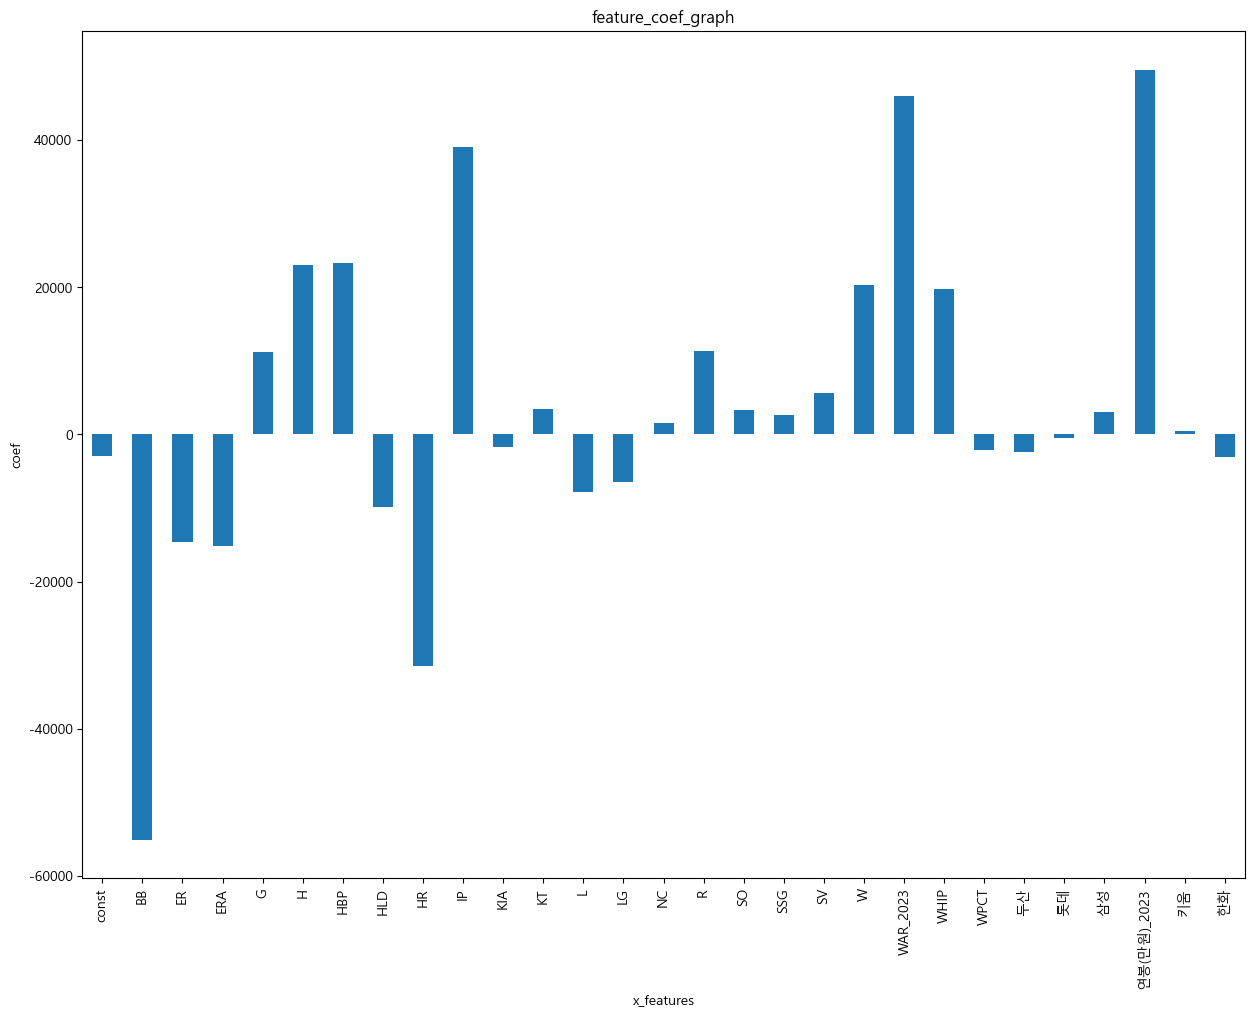

In [44]:
# OLS로 앞서 구한 계수들을 시각화 해본다.
plt.rc('font', family='Malgun Gothic')
plt.rcParams['figure.figsize'] = [15,11]

coefs = model_.params.tolist()
coefs_series = pd.Series(coefs)
x_labels = model_.params.index.tolist()

ax = coefs_series.plot(kind='bar')
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)
plt.show()

# 상관관계 분석(분산 팽창요인 파악)

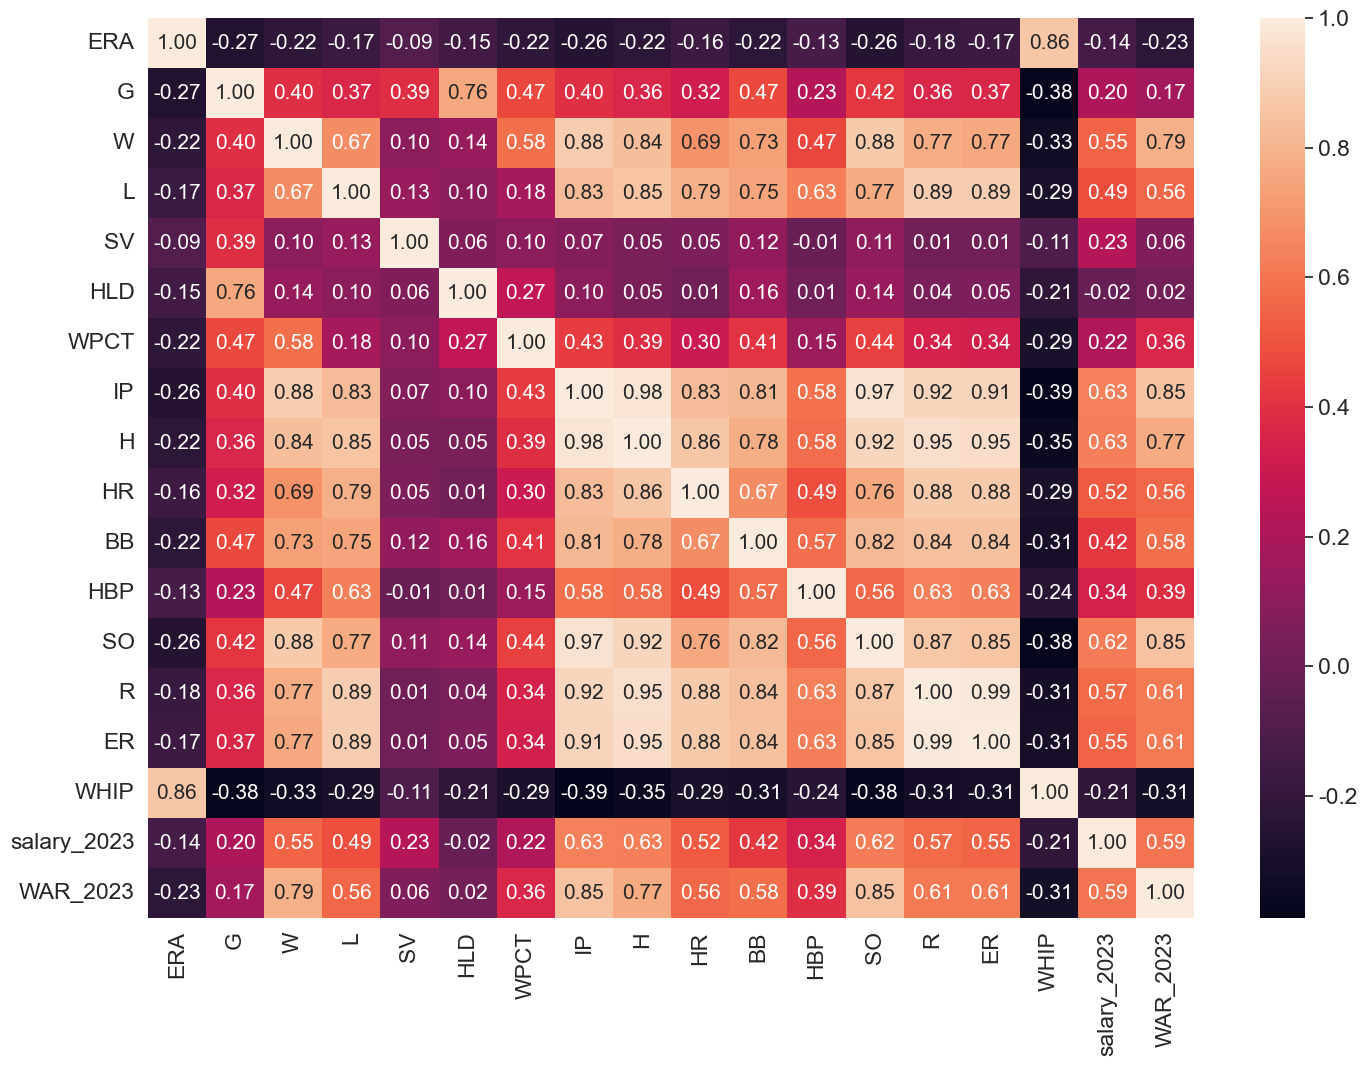

In [45]:
# 피어슨 방식으로 상관계수를 구해본다.
show_cols = ['ERA', 'G', 'W', 'L', 'SV', 'HLD', 'WPCT', 'IP', 'H', 'HR', 
                'BB', 'HBP', 'SO', 'R', 'ER', 'WHIP', '연봉(만원)_2023', 'WAR_2023']

corr = scaled_players[show_cols].corr(method='pearson')

show_cols = ['ERA', 'G', 'W', 'L', 'SV', 'HLD', 'WPCT', 'IP', 'H', 'HR', 
                 'BB', 'HBP', 'SO', 'R', 'ER', 'WHIP', 'salary_2023', 'WAR_2023']

sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
                cbar=True,
                annot=True,
                fmt = '.2f',
                annot_kws={'size': 15},
                yticklabels=show_cols,
                xticklabels=show_cols
                )
plt.tight_layout()
plt.show()

In [46]:
# 다중 공선성을 살펴보고 분산팽창요인(VIF 계수로 평가)으로 예측에 방해되는 컬럼을 조사해본다.
def VIF_evaluation():
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['features'] = X.columns
    vif.round(1)
    return vif

In [47]:
# VIF 파악하기
vif = VIF_evaluation()
vif

,VIF Factor,features
0,8.745007,BB
1,99.421160,ER
2,4.862311,ERA
3,9.166333,G
4,77.507489,H
5,2.104411,HBP
6,5.155835,HLD
7,6.347835,HR
8,222.336636,IP
9,2.235330,KIA


In [48]:
# 분산팽창요인이 15가 넘는 피쳐들을 조사한다.
vif.loc[vif['VIF Factor'] >= 15]

,VIF Factor,features
1,99.421160,ER
4,77.507489,H
8,222.336636,IP
14,150.365448,R
15,25.455163,SO
19,28.957772,WAR_2023


In [49]:
# 최종적으로 다음과 같은 열을 제외하고 피쳐들을 선택해 모델학습을 시킨다.
X = scaled_players[scaled_players.columns.difference(['IP', 'ER', 'H', 'SO','R','y'])]

y = scaled_players['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, shuffle=True)

model = LinearRegression()
model.fit(X, y)

# 모델 평가 
model_evaluation()

#VIF 평가
VIF_evaluation()

training set에서 성능
-----------------------
오차: 11514.012497612975
testing set에서 성능
-----------------------
오차: 12336.019027515998
0.7705893830871129
0.8436996729320169


,VIF Factor,features
0,3.758652,BB
1,4.303669,ERA
2,7.440765,G
3,1.986624,HBP
4,4.445315,HLD
5,3.931592,HR
6,1.944600,KIA
7,1.729184,KT
8,5.003604,L
9,2.167790,LG


# 예측값 최종 시각화

In [50]:
# 최종적으로 예측한 것을 시각화한다.
players = pd.read_excel('player_stats.xlsx')
picher = players[['선수명', '연봉(만원)_2023']]

predict_2024_salary = model.predict(X)

last_players['예측연봉(2024)'] = pd.Series(predict_2024_salary)

result_df = last_players.sort_values(by=['y'], ascending=False)
result_df.drop(['연봉(만원)_2023'], axis=1, inplace=True, errors='ignore')
result_df = result_df.merge(picher, on='선수명', how='left')
result_df = result_df[['선수명', 'y', '예측연봉(2024)', '연봉(만원)_2023']]
result_df.columns = ['선수명', '실제연봉(2024)', '예측연봉(2024)', '작년연봉(2023)']

result_df = result_df[result_df['작년연봉(2023)'] != result_df['실제연봉(2024)']]
#result_df['실제연봉(2024)'] = result_df['실제연봉(2024)'].str.replace(',', '').astype(float)
result_df['작년연봉(2023)'] = result_df['작년연봉(2023)'].str.replace(',', '').astype(float)
result_df.sort_values(by='실제연봉(2024)', inplace=True, ascending=False)
result_df = result_df.reset_index()
result_df = result_df.iloc[:10, :]
result_df.head(10)

,index,선수명,실제연봉(2024),예측연봉(2024),작년연봉(2023)
0,0,고영표,200000.0,99886.498008,43000.0
1,1,박세웅,135000.0,117788.444112,150000.0
2,2,후라도,120000.0,120378.638106,85000.0
3,3,박종훈,110000.0,50497.512801,50000.0
4,4,쿠에바스,100000.0,78852.143618,45000.0
5,5,김광현,100000.0,83113.948233,100000.0
6,6,벤자민,90000.0,89094.408808,100000.0
7,7,반즈,85000.0,115796.696833,85000.0
8,8,켈리,80000.0,86148.975926,105000.0
9,9,알칸타라,80000.0,77403.307996,50000.0


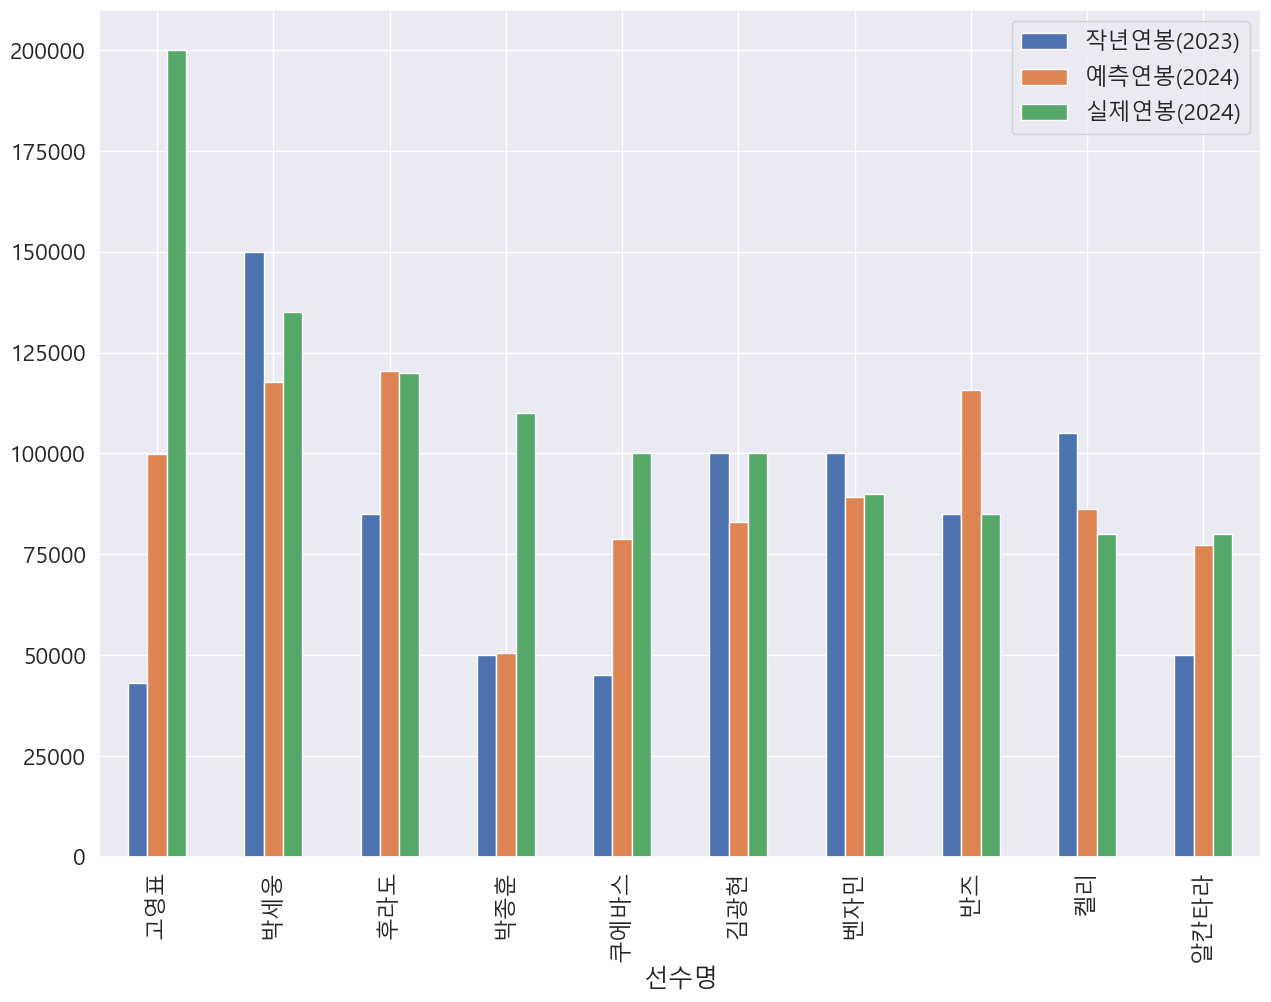

In [51]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
result_df.plot(x='선수명', y=['작년연봉(2023)', '예측연봉(2024)', '실제연봉(2024)'], kind='bar')
plt.show()